In [1]:
# Preamble
import concurrent.futures
import matplotlib.pyplot as plt
# import pprint
import random
import time
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed, wait
%matplotlib inline

from helpers import fetch_datum, store_output, n_fibonacci, digits_fibonacci
# fetch_datum = fake_io
# store_output = fake_io

random.seed(42)
# print = pprint.pprint

Visualizing `concurrent.futures`
===================

This notebook shows how the `concurrent.future` module can be used to speed up the running time of a data processing task that involves an arbitrary number of similar sub-tasks.

Our 'data processing' task consists in calculating the nth Fibonacci number $F_n$, given an input $n$.

The Fibonacci sequence is defined as follows:

$$
F_n = F_{n-1} + F_{n-2}
$$
with seed values $F_0 = 0$ and $F_1 = 1$ [see more].

[see more]: https://en.wikipedia.org/wiki/Fibonacci_number

In [2]:
fibonacci_sequence = [
    n_fibonacci(n) for n in range(10)
]
fibonacci_sequence

[0, 1, 1, 2, 3, 5, 8, 13, 21, 34]

Processing is quite fast for small integers:

In [3]:
%time n_fibonacci(10)
# random.random()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.2 µs


55

and it gets slower for larger numbers:

In [4]:
%time n_fibonacci(20000)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 6.81 ms


2531162323732361242240155003520607291766356485802485278951929841991312781760541315230153423463758831637443488219211037689033673531462742885329724071555187618026931630449193158922771331642302030331971098689235780843478258502779200293635651897483309686042860996364443514558772156043691404155819572984971754278513112487985892718229593329483578531419148805380281624260900362993556916638613939977074685016188258584312329139526393558096840812970422952418558991855772306882442574855589237165219912238201311184749075137322987656049866305366913734924425822681338966507463855180236283582409861199212323835947891143765414913345008456022009455704210891637791911265475167769704477334859109822590053774932978465651023851447920601310106288957894301592502061560528131203072778677491443420921822590709910448617329156135355464620891788459566081572824889514296350670950824208245170667601726417091127999999941149913010424532046881958285409468463211897582215075436515584016297874572183907949257286261608612401379639484713

The last output shows how large the 20000th Fibonacci number actually is.  
What if we just checked the number of digits in the nth Fibonacci number?

In [5]:
%time digits_fibonacci(int(2E5))

CPU times: user 468 ms, sys: 0 ns, total: 468 ms
Wall time: 473 ms


41798

(This is done purely to avoid output flooding) :-D

### Define a list of inputs

Nothing fancy here. Thsi is a uniform distribution of numbers in the range $200000 \pm 50000$.

In [8]:
input_numbers = [
    int(2E5) + random.randint(-1E5, 1E5) // 2 for __ in range(16)
]
print(input_numbers)

[154165, 153905, 162280, 178657, 180495, 216237, 228907, 153478, 223563, 176062, 243850, 235181, 241924, 221426, 204987, 178893]


Let's see how they look:

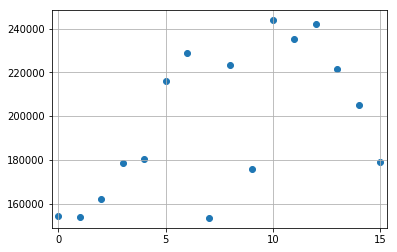

In [10]:
plt.scatter(range(len(input_numbers)), input_numbers)
plt.xlim(-0.3, 15.3)
plt.xticks([0, 5, 10, 15])
plt.grid();

One should factor in some additional time for read/write from/to disk/API, or the I/O of choice:

In [11]:
%%time
data_in = fetch_datum(int(2e4)) # e.g read data from disk/API
n_digits = digits_fibonacci(data_in)
print(store_output(n_digits)) # e.g. write data to disk/API

4180
CPU times: user 28 ms, sys: 0 ns, total: 28 ms
Wall time: 574 ms


Let's see how long the whole process takes:

In [12]:
%%time
for n in input_numbers:
    fetch_datum(n) # e.g read data from disk/API
    n_digits = digits_fibonacci(n)
    print(store_output(n_digits), end=" ") # e.g. write data to disk/API
print()

32219 32164 33915 37337 37721 45191 47839 32075 46722 36795 50962 49150 50559 46275 42840 37387 
CPU times: user 7.36 s, sys: 0 ns, total: 7.36 s
Wall time: 16.7 s


Let's take a closer look, using checkpoints at each step:

In [13]:
%%time
start = time.time()
seq_checkpoints = []
seq_checkpoints.append(time.time() - start)
for n in input_numbers:
    fetch_datum(n) # e.g read data from disk/API
    seq_checkpoints.append(time.time() - start)
    n_digits = digits_fibonacci(n)
    seq_checkpoints.append(time.time() - start)
    print(store_output(n_digits), end=" ") # e.g. write data to disk/API
    seq_checkpoints.append(time.time() - start)
print()

32219 32164 33915 37337 37721 45191 47839 32075 46722 36795 50962 49150 50559 46275 42840 37387 
CPU times: user 7.34 s, sys: 0 ns, total: 7.34 s
Wall time: 17 s


We can now visualize the time taken by each task, in sequential order.

(0, 4)

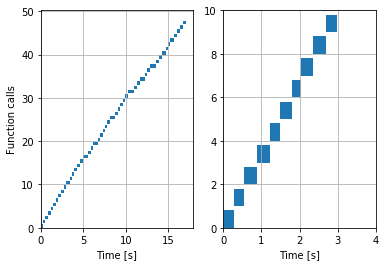

In [14]:
seq_widths = [
    x - y for x, y in zip(seq_checkpoints[1:], seq_checkpoints[:-1])
]
# plt.figure(figsize=(12,8))
fig, axes = plt.subplots(1, 2)
# plt.title("Functions time usage")
for ax in axes:
    ax.barh(range(len(seq_checkpoints[1:])), seq_widths, left=seq_checkpoints[:-1], align='edge')
    ax.set_ylim((0, None))
    ax.set_xlabel("Time [s]")
#     plt.xlabel("Time [s]")
    ax.grid()
axes[0].set_ylabel("Function calls")
axes[1].set_ylim((0,10))
axes[1].set_xlim((0,4))
# plt.plot(seq_checkpoints[::2], 'o-')

The plot on the right is just a magnification of the left.

### CPU vs I/O time usage analysis

We can group our processing steps into "pure computation" and read/write tasks.
It will soon become apparent why this is interesting:

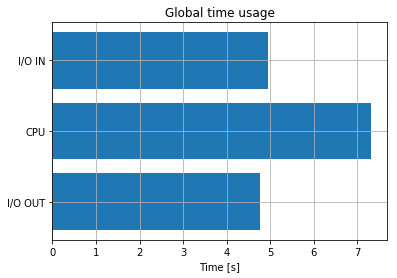

In [15]:
io_in = sum(seq_widths[::3])
cpu = sum(seq_widths[1::3])
io_out = sum(seq_widths[2::3])

ax = plt.barh(range(3), [io_out, cpu, io_in])
plt.title("Global time usage")
plt.xlabel("Time [s]")
# plt.ylabel("Function calls")
plt.yticks(range(3), ("I/O OUT", "CPU", "I/O IN"))
plt.grid()

Overall 10 seconds are spent in I/O operations and 7 seconds in CPU operations.

## Concurrency in Python

Using the `concurrent.futures` module, it is quite straightforward to leverage concurrency.
The module provides an easy-to-use API for using multiple threads or processes in Python.

The main construct of the module is the *Executor* class, which interfaces to a pool
of workers (threads or processes).
The executor can receive work (our functions), distribute it to the pool, and give back results.

An *Executor* implements two main methods:

- **map()**: equivalent to the standard *map()* function, only allowing asynchronous calls.
  Returns an iterator object.
- **submit()**: This methods accepts a callable (e.g. a function) and arguments and schedules it
  to be executed by the pool of workers.
  The method returns a *Future* object, representing the execution of the callable.
  This object has a *result()* method, that returns the value returned by the call,
  once the execution is done.


See the full documentation [here](https://docs.python.org/3/library/concurrent.futures.html).

<!--The easiest entity to use are threads, so let's try that first.-->

The simplest way to leverage `concurrent.futures` is arguably using the *map* method.
This, however, requires a slight rewriting of the code.

Here's the sequential version:

In [28]:
start = time.time()

data_in = list(map(fetch_datum, input_numbers)) # e.g read data from disk/API

processed_data = list(map(digits_fibonacci, data_in))

data_out = list(map(store_output, processed_data)) # e.g. write data to disk/API
print(data_out)

print("{} secs".format(time.time() - start))

[32219, 32164, 33915, 37337, 37721, 45191, 47839, 32075, 46722, 36795, 50962, 49150, 50559, 46275, 42840, 37387]
16.401336431503296 secs


### Multithreading

Once the code is rewritten this way (this is a more [functional](https://en.wikipedia.org/wiki/Functional_programming) style BTW)
it's straightforward to write the concurrent version.  
The only difference is in the use of the executor within a context manager
and the *map* executor method instead of the built-in python *map*.

In [81]:
start = time.time()
tp_chkpts = [] # Checkpoints list
tp_chkpts.append(time.time() - start)  # Checkpoint

with ThreadPoolExecutor() as tp:
    data_in = list(tp.map(fetch_datum, input_numbers)) # e.g read data from disk/API
    check = time.time() - start
    print(check)
    tp_chkpts.append(check)  # Checkpoint
    
    processed_data = list(tp.map(digits_fibonacci, data_in))
    check = time.time() - start
    print(check)
    tp_chkpts.append(check)  # Checkpoint
    
    data_out = tp.map(store_output, processed_data) # e.g. write data to disk/API
print(list(data_out))
tp_chkpts.append(time.time() - start)  # Checkpoint

print("{} secs".format(time.time() - start))  # Total time

0.3959057331085205
15.792449712753296
[32219, 32164, 33915, 37337, 37721, 45191, 47839, 32075, 46722, 36795, 50962, 49150, 50559, 46275, 42840, 37387]
16.193178176879883 secs


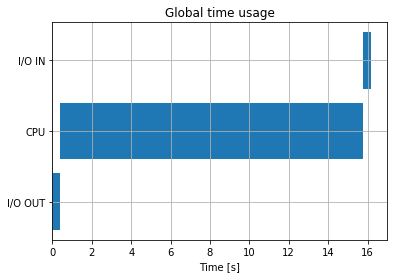

In [82]:
tp_widths = [
    x - y for x, y in zip(tp_chkpts[1:], tp_chkpts[:-1])
]
# plt.figure(figsize=(12,8))
plt.barh(range(len(tp_chkpts[1:])), tp_widths, left=tp_chkpts[:-1])
# plt.plot(tp_chkpts[::2], 'o-')
plt.xlabel("Time [s]")
# plt.ylabel("Function calls")

# plt.barh(range(3), [io_out, cpu, io_in])
plt.title("Global time usage")
plt.xlabel("Time [s]")
# plt.ylabel("Function calls")
plt.yticks(range(3), ("I/O OUT", "CPU", "I/O IN"))
plt.grid()

There is some sort of improvement in this case, even though not substantial.

Any idea why?

### Multiprocessing

To switch from threads to processes is just a matter of using
the same syntax but with a `ProcessPoolExecutor` instead.

In [83]:
start = time.time()
pp_chkpts = []
pp_chkpts.append(time.time() - start)
with ProcessPoolExecutor() as pp:
    data_in = list(pp.map(fetch_datum, input_numbers)) # e.g read data from disk/API
    pp_chkpts.append(time.time() - start)
    processed_data = list(pp.map(digits_fibonacci, data_in))
    pp_chkpts.append(time.time() - start)
    data_out = pp.map(store_output, processed_data) # e.g. write data to disk/API
    print(list(data_out))
    pp_chkpts.append(time.time() - start)
print("{} secs".format(time.time() - start))

[32219, 32164, 33915, 37337, 37721, 45191, 47839, 32075, 46722, 36795, 50962, 49150, 50559, 46275, 42840, 37387]
4.659945011138916 secs


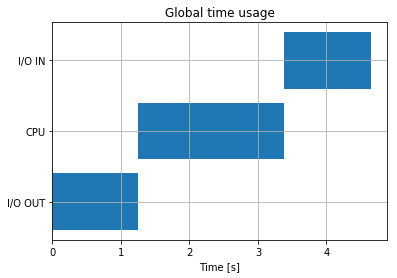

In [84]:
pp_widths = [
    x - y for x, y in zip(pp_chkpts[1:], pp_chkpts[:-1])
]
# plt.figure(figsize=(12,8))
plt.barh(range(len(pp_chkpts[1:])), pp_widths, left=pp_chkpts[:-1])
# plt.plot(pp_chkpts[::2], 'o-')
# plt.xlabel("Time [s]")
# plt.ylabel("Function calls")
# plt.grid()
plt.title("Global time usage")
plt.xlabel("Time [s]")
# plt.ylabel("Function calls")
plt.yticks(range(3), ("I/O OUT", "CPU", "I/O IN"))
plt.grid()

This is looking better.
As expected, we get 4x speedup on a 4-core machine.

### Mixin' it up

One can actually use both thread and process pools in the same program and get the best of both worlds:

In [64]:
%%time
start = time.time()
pt_chkpts = []
pt_chkpts.append(time.time() - start)
with ProcessPoolExecutor() as pp:
    with ThreadPoolExecutor() as tp:
        data_in = list(tp.map(fetch_datum, input_numbers))
        pt_chkpts.append(time.time() - start)
        processed_data = list(pp.map(digits_fibonacci, data_in))
        pt_chkpts.append(time.time() - start)
        data_out = list(tp.map(store_output, processed_data))
        print(data_out)
        pt_chkpts.append(time.time() - start)
#         print(list(tp.map(fake_io, processed_data)))

[32219, 32164, 33915, 37337, 37721, 45191, 47839, 32075, 46722, 36795, 50962, 49150, 50559, 46275, 42840, 37387]
CPU times: user 20 ms, sys: 24 ms, total: 44 ms
Wall time: 2.92 s


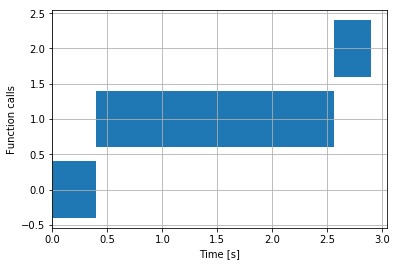

In [65]:
pt_widths = [
    x - y for x, y in zip(pt_chkpts[1:], pt_chkpts[:-1])
]
# plt.figure(figsize=(12,8))
plt.barh(range(len(pt_chkpts[1:])), pt_widths, left=pt_chkpts[:-1])
# plt.plot(pt_chkpts[::2], 'o-')
plt.xlabel("Time [s]")
plt.ylabel("Function calls")
plt.grid()

### Using futures

Submitting work to the pool and using its scheduling capability with the *Future* object can lead to very efficient code:

In [86]:
%%time
start = time.time()
tt_chkpts = []
tt_chkpts.append(time.time() - start)
with ThreadPoolExecutor() as tp:
        data_in = [
            tp.submit(fetch_datum, i) for i in input_numbers
        ]
        # This slows down things but it's necessary for recording time
        wait(data_in)
        tt_chkpts.append(time.time() - start)
        processed_data = [
            digits_fibonacci(f.result()) for f in as_completed(data_in)
        ]
        tt_chkpts.append(time.time() - start)
        data_out = [
            tp.submit(store_output, d) for d in processed_data
        ]
        for f in as_completed(data_out):
            print(f.result())
        tt_chkpts.append(time.time() - start)
#         print(list(tp.map(fake_io, processed_data)))

50559
36795
45191
32075
33915
47839
42840
46722
37721
46275
32219
32164
49150
37387
50962
37337
CPU times: user 6.97 s, sys: 0 ns, total: 6.97 s
Wall time: 7.75 s


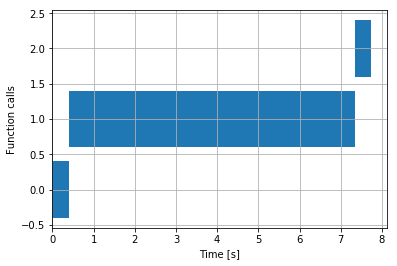

In [87]:
tt_widths = [
    x - y for x, y in zip(tt_chkpts[1:], tt_chkpts[:-1])
]
# plt.figure(figsize=(12,8))
plt.barh(range(len(tt_chkpts[1:])), tt_widths, left=tt_chkpts[:-1])
# plt.plot(tt_chkpts[::2], 'o-')
plt.xlabel("Time [s]")
plt.ylabel("Function calls")
plt.grid()

In this case it's apparent how the I/O tasks are extremely optimized by the use of a pool of threads, while the CPU-bound work follows the same performance of the sequential code.

### Summary

Let's summarize the performance of different configurations.

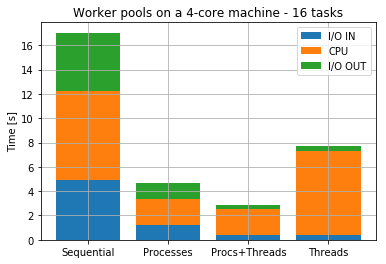

In [88]:
io_in, cpu, io_out = [], [], []
options = {
    "Sequential": seq_widths,
    "Processes": pp_widths,
    "Procs+Threads": pt_widths,
    "Threads": tt_widths
}

# plt.figure(figsize=(14,4))
for name, widths in options.items():
    io_in.append(
        sum(widths[::3])
    )
    cpu.append(
        sum(widths[1::3])
    )
    io_out.append(
        sum(widths[2::3])
    )
plt.bar(range(4), io_in, label="I/O IN")
plt.bar(range(4), cpu, bottom=io_in, label="CPU")
plt.bar(range(4), io_out, bottom=[a + b for a,b in zip(cpu, io_in)], label="I/O OUT")
plt.xticks(range(4), (
    "Sequential",
    "Processes",
    "Procs+Threads",
    "Threads",
))
plt.ylabel("Time [s]")
plt.title("Worker pools on a 4-core machine - 16 tasks")
plt.grid()
plt.legend();

From the plot it's apparent how the combination of both multiple processes and threads delivers the best performance.
The pool of processes comes in second, while the pool of threads alone is third.

It's worth noting how second and third place would exchange places depending on the nature of the program.
In case of I/O-bound work, threads are usually the best solution,
while processes work best for CPU-bound work.

### Scaling with number of tasks

CPU times: user 7.3 s, sys: 2.18 s, total: 9.47 s
Wall time: 27.2 s


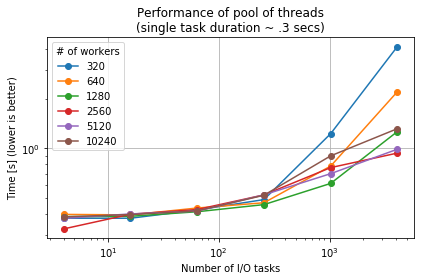

In [26]:
%%time
times = []
th_startups = []
task_numbers = [2**x for x in range(2, 13, 2)] 
workers_numbers = [5*2**x for x in range(6, 12)]
for n_workers in workers_numbers:
    startup_start = time.time()
    with ThreadPoolExecutor(n_workers) as tp:
        th_startups.append(time.time() - startup_start)
        for n_tasks in task_numbers:
            start = time.time()
            list(tp.map(fake_io, range(n_tasks)))
            times.append(time.time() - start)
    plt.plot(task_numbers, times, '-o', label=n_workers)
    times = []
plt.grid()
plt.legend(title="# of workers")
plt.title("Performance of pool of threads\n(single task duration ~ .3 secs)")
plt.ylabel("Time [s] (lower is better)")
plt.xlabel("Number of I/O tasks");
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.savefig("images/threads.png", dpi=150);

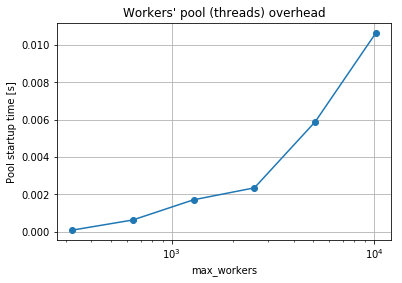

In [27]:
plt.plot(workers_numbers, th_startups, 'o-')
plt.title("Workers' pool (threads) overhead")
plt.xlabel("max_workers")
plt.ylabel("Pool startup time [s]")
plt.xscale('log')
plt.grid();